Margaux Bailleul 21906121
Clémence CHESNAIS 21901191

# Import des modules

In [80]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import regex as re
from collections import defaultdict, Counter
from sklearn.model_selection import train_test_split
import nltk
from nltk.tokenize import word_tokenize, TweetTokenizer
from nltk.stem.snowball import FrenchStemmer 

In [81]:
!pip install -U spacy
!python -m spacy download fr_core_news_sm
import spacy
nlp = spacy.load('fr_core_news_sm')


     ---------------------------------------- 0.0/16.3 MB ? eta -:--:--
     ---------------------------------------- 0.0/16.3 MB ? eta -:--:--
     --------------------------------------- 0.0/16.3 MB 162.5 kB/s eta 0:01:40
     --------------------------------------- 0.0/16.3 MB 186.2 kB/s eta 0:01:28
     --------------------------------------- 0.1/16.3 MB 290.5 kB/s eta 0:00:56
     --------------------------------------- 0.1/16.3 MB 326.8 kB/s eta 0:00:50
     --------------------------------------- 0.2/16.3 MB 610.0 kB/s eta 0:00:27
      -------------------------------------- 0.3/16.3 MB 983.9 kB/s eta 0:00:17
      --------------------------------------- 0.4/16.3 MB 1.2 MB/s eta 0:00:14
     - -------------------------------------- 0.6/16.3 MB 1.5 MB/s eta 0:00:11
     - -------------------------------------- 0.8/16.3 MB 1.8 MB/s eta 0:00:09
     -- ------------------------------------- 1.1/16.3 MB 2.5 MB/s eta 0:00:07
     --- ------------------------------------ 1.5/16.3 MB 3.

# 1. Importation des données

In [82]:
# import du fichier csv
data = pd.read_csv('french_books_reviews.csv', sep=',')
data.head()

,Unnamed: 0,book_title,author,reader_review,rating,label
0,0,Le Démon de la Colline aux Loups,Dimitri Rouchon-Borie,Ce n'est pas le premier roman à aborder les th...,5.0,1
1,1,Simple,Marie-Aude Murail,"Simple, alias Barnabé, est un jeune homme de 2...",4.0,1
2,2,La plus secrète mémoire des hommes,Mohamed Mbougar Sarr,Pour écrire La plus secrète mémoire des hommes...,4.0,1
3,3,Trancher,Amélie Cordonnier,« La violence d'Aurélien est revenue. Par la f...,3.5,0
4,4,"La guerre d'Alan, tome 2",Emmanuel Guibert,"Dans ce second album de La Guerre d’Alan, Emma...",5.0,1


Dans ce jeu de données nous disposons de 3 variables qualitatives et 2 variables quantitatives. 
Pour notre étude, nous avons le titre du livre, l'auteur, l'avis du lecteur, la note qu'il a attribué au livre ainsi qu'un label correspondant à la polarité de l'avis. Si l'avis est positif, le label vaut 1, s'il est neutre, il vaut 0 et s'il est négatif, il vaut -1.

## 1.1. Statistiques descriptives

Tout d'abord, nous commençons par regarder si la base de données contient des valeurs manquantes.

In [83]:
data["reader_review"].isna().sum()

13

13 lignes contiennent des valeurs manquantes. Nous décidons de les supprimer car elles ne représentent que 0.1% de la base de données.
De plus, nous souhaitons étudiés les avis des clients, il n'y a donc pas d'intérêt à garder les lignes où il n'y a pas d'avis.

In [84]:
data = data.dropna(subset=['reader_review'])

Nous vérifions qu'il ne reste plus de ligne sans avis.

In [85]:
data["reader_review"].isna().sum()

0

Nous regardons combien il y a d'avis pour chacune des polarités.

In [86]:
data["label"].value_counts()

polarity_distribution= (pd.DataFrame.from_dict(Counter(data.label.values),
                                             orient='index')
                                  .rename(columns={0: 'nb_reviews'}))
polarity_distribution.index.name = 'class'
polarity_distribution

,nb_reviews
class,
1,6658
0,2129
-1,858


Dans ce jeu de données, il y a 6670 positifs, 2129 neutres et 859 négatifs.

Nous calculons le pourcentage d'avis pour chaque polarité.

In [87]:
polarity_distribution['pourcentage'] = np.around(polarity_distribution.nb_reviews /
                                                np.sum(polarity_distribution.nb_reviews),
                                                2)
polarity_distribution

,nb_reviews,pourcentage
class,,
1,6658,0.69
0,2129,0.22
-1,858,0.09


Nous représentons sur un graphique la distributions des polarités selon le nombre d'avis de livre

<Axes: title={'center': "Nombre d'avis par classe"}, xlabel='class'>

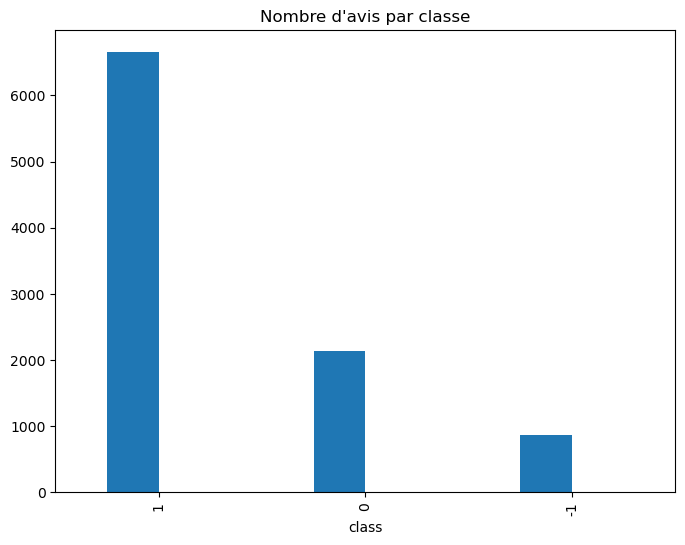

In [88]:
polarity_distribution.plot(kind='bar', figsize=(8, 6), legend=False, 
                           title="Nombre d'avis par classe")

Nous affichons les 5 premiers avis pour voir à quoi ressemble les données.


In [89]:
for i in list(data['reader_review'][0:10]):
    print(i)
    print('------------------------')

Ce n'est pas le premier roman à aborder les thèmes lourds de l'inceste et de l'enfance martyre, mais il le fait avec une audace et un brio incomparables qui rendent ce livre marquant dans une vie de lecteur. On y sent à quel point l'auteur n'a pas cherché à "faire quelque chose", on ne sent jamais l'intention, on sent juste l'urgence, incandescente, à raconter la vérité d'un homme maltraité par la vie au point de dire à la nuit «  tu ne me feras pas peur j'ai plus de noir que toi dans mon enfance ».
------------------------
Simple, alias Barnabé, est un jeune homme de 22 ans qui a l’âge mental d’un enfant de 3 ans. Kléber, son frère de 17 ans, entre en terminale au lycée, mais décide de s’occuper lui-même de son frère. Leur mère étant morte et leur père refusant de s’encombrer de sa progéniture afin de vivre pleinement sa nouvelle vie, Kléber refuse d’abandonner son frère à Malicroix, l’institution où il dépérissait. Se mettant tant bien que mal à la recherche d’un appartement pour viv

On remarque que certains avis ne sont pas réellement des avis mais un résumé du livre. Ces derniers devront être classé dans la catégorie neutre.

# 1.2. Séparation des données

Nous séparons les données en deux jeux de données : un jeu d'entrainement et un jeu de test.

In [90]:
# On mélange les lignes du DataFrame
data = data.sample(frac=1, random_state=42).reset_index(drop=True)

# On utilise la fonction train_test_split pour diviser le DataFrame
train_df, test_df = train_test_split(data, train_size=2/3, random_state=42)

# On affiche les informations sur les ensembles d'entraînement et de test
print("Taille de l'ensemble d'entraînement :", len(train_df))
print("Taille de l'ensemble de test :", len(test_df))

Taille de l'ensemble d'entraînement : 6430
Taille de l'ensemble de test : 3215


# 2. Prétraitement des données

## 2.1 Lemmatisation

Lemmatiser un texte implique de réduire chaque mot à sa forme de base ou à son "lemme".
Cela implique la suppression des variations grammaticales (comme les temps verbaux, les genres, les nombres, etc.) pour regrouper les mots qui ont la même signification de base

La lemmatisation est souvent utilisée pour améliorer la précision de l'analyse en réduisant les variations de mots à leur forme canonique. Cela aide à regrouper les mots apparentés et à réduire la complexité lors de l'analyse textuelle. 

In [91]:
def lemmatisation(text):
    text = nlp(text)
    lemmas = [token.lemma_ for token in text]
    return ' '.join(lemmas)

On applique la lemmatisation sur les avis des livres des jeux de données d'aprentissage et de test.

In [92]:
train_df['reader_review'] = train_df['reader_review'].fillna('')
train_df['reader_review'] = train_df['reader_review'].apply(lemmatisation)

In [93]:
for i in list(train_df['reader_review'][1:5]):
    print(i)
    print('------------------------')

«    mais alors ! le père Noël exister -t il ?   » , pour - raton se demander à le lecture de ce guide qui donne envie de s’ offrir enfin à soi - même de cadeau utile ? pouvoir - être , mais ce qu’ il y avoir de certain , c’ être qu’ on y parler très peu de le mère Noël qui avoir perdre son châle .
------------------------
je retrouver avec beaucoup de joie l’ auteure , Marjane satrapi m’ avoir éblouir par son maturité dans Persépolis et je le retrouve tout aussi excellent dans Poulet à prune . on débarquer à Téhéran en 1958 , on retrouver le famille de l’ auteure dans ce opus mais pas de souci si vous n’ avoir pas lire Persépolis , c’ être un histoire inédit qu’ lui nous présente , toutefois je vous le conseil , il être magnifique .
------------------------
récit feuilletonnesque à souhait écrire par un duma jamais en manque de imagination . le aventure de Edmond Dantes être universel dans le mesure où lui pouvoir être délocaliser souher pour se inscrire dans ne importer quel pays . l

Nous faisons la même chose pour le jeu de données de test.

In [94]:
test_df['reader_review'] = test_df['reader_review'].fillna('')
test_df['reader_review'] = test_df['reader_review'].apply(lemmatisation)

In [95]:
for i in list(test_df['reader_review'])[1:5]:
    print(i)
    print('------------------------')

et s’ il falloir choisir celui qui être sauver ?
------------------------
se attaquer à 667 page ( dense ) de ce biographie de Fouché pouvoir apparaître comme un challenge . mais le talent de historien de Emmanuel de Waresquiel avoir vite faire de donner le envie de parcourir ce ouvrage avec détermination !
------------------------
ce ouvrage plaire à petit comme à grand , à adepte de beal livre illustrer comme à sorcière et sorcier en herbe .
------------------------
livre fantastique remplir de émotion de début à le fin . le lecture de un chapitre me donner envie de connaître le suite . je avoir dévorer ce livre . par contre , quand le fin arriver , quel tristesse de laisser ce personnage . je avoir envier de continuer un petit bout de chemin avec lui .
------------------------


## 2.2. Racine des mots

Nous remplaçons les mots par leur racine. Cela permet de réduire la complexité lors de l'analyse textuelle.

In [96]:
def stem_text(text):
    tokenizer = TweetTokenizer(strip_handles=True, reduce_len=True)
    stemmer = FrenchStemmer('french')
    stems = [stemmer.stem(token) for token in tokenizer.tokenize(text)]
    return ' '.join(stems)

In [97]:
train_df['stems'] = train_df['reader_review'].apply(stem_text)

In [98]:
for i in list(train_df['stems'])[1:5]:
    print(i)
    print('------------------------')

« mais alor ! le per noël exist - t il ? » , pour - raton se demand à le lectur de ce guid qui don envi de s ’ offrir enfin à soi - même de cadeau util ? pouvoir - être , mais ce qu ’ il y avoir de certain , c ’ être qu ’ on y parl tres peu de le mer noël qui avoir perdr son châl .
------------------------
je retrouv avec beaucoup de joi l ’ auteur , marjan satrap m ’ avoir éblou par son matur dans persépol et je le retrouv tout auss excellent dans poulet à prun . on débarqu à téhéran en 1958 , on retrouv le famill de l ’ auteur dans ce opus mais pas de souc si vous n ’ avoir pas lir persépol , c ’ être un histoir ined qu ’ lui nous présent , toutefois je vous le conseil , il être magnif .
------------------------
rec feuilletonnesqu à souh écrir par un dum jam en manqu de imagin . le aventur de edmond dant être universel dans le mesur où lui pouvoir être délocalis souh pour se inscrir dans ne import quel pay . le auteur parl ici d vengeanc et de droit à le justic . en se serv de son f

Nous faisons la même chose pour le jeu de données de test.

In [99]:
test_df['stems'] = test_df['reader_review'].apply(stem_text)

In [100]:
for i in list(test_df['stems'][1:5]):
    print(i)
    print('------------------------')

et s ’ il falloir chois celui qui être sauv ?
------------------------
se attaqu à 667 pag ( dens ) de ce biograph de fouch pouvoir apparaîtr comm un challeng . mais le talent de historien de emmanuel de waresquiel avoir vit fair de don le envi de parcour ce ouvrag avec détermin !
------------------------
ce ouvrag plair à pet comm à grand , à adept de beal livr illustr comm à sorci et sorci en herb .
------------------------
livr fantast rempl de émot de début à le fin . le lectur de un chapitr me don envi de connaîtr le suit . je avoir dévor ce livr . par contr , quand le fin arriv , quel tristess de laiss ce personnag . je avoir envi de continu un pet bout de chemin avec lui .
------------------------


## 2.3. Etiqutage morphosyntaxique

In [101]:
def replace_words_with_pos_tag(text):
    text = nlp(text)
    return ' '.join([token.pos_ for token in text])

In [102]:
train_df['pos'] = train_df['reader_review'].apply(replace_words_with_pos_tag)

In [103]:
train_df[1:5]

,Unnamed: 0,book_title,author,reader_review,rating,label,stems,pos
3855,6198,Le guide du Noël parfait,Docteur Guido,« mais alors ! le père Noël exister -t il ?...,5.0,1,"« mais alor ! le per noël exist - t il ? » , p...",NOUN SPACE CCONJ ADV PUNCT DET NOUN PROPN VERB...
2514,1844,Poulet aux prunes,Marjane Satrapi,je retrouver avec beaucoup de joie l’ auteure ...,4.5,1,"je retrouv avec beaucoup de joi l ’ auteur , m...",PRON VERB ADP ADV ADP VERB DET NOUN NOUN PUNCT...
5440,8277,"Le comte de Monte-Cristo, tome 1",Alexandre Dumas,récit feuilletonnesque à souhait écrire par un...,4.5,1,rec feuilletonnesqu à souh écrir par un dum ja...,NOUN ADJ ADP NOUN ADJ ADP DET NOUN ADV ADP NOU...
2917,4924,Questions de maths sympas : Pour M. Et Mme Tou...,Hervé Lehning,ce être un livre très agréable à lire . le aut...,4.0,1,ce être un livr tres agréabl à lir . le auteur...,PRON AUX DET NOUN ADV ADJ ADP VERB PUNCT DET N...


Nous faisons la même chose pour le jeu de données de test.

In [104]:
test_df['pos'] = test_df['reader_review'].apply(replace_words_with_pos_tag)

In [105]:
test_df[1:5]

,Unnamed: 0,book_title,author,reader_review,rating,label,stems,pos
1543,6591,La fin des temps,Jean-Louis Vincent (II),et s’ il falloir choisir celui qui être sauver ?,5.0,1,et s ’ il falloir chois celui qui être sauv ?,CCONJ PRON VERB PRON VERB AUX PRON PRON AUX VE...
6056,3561,Fouché : Les silences de la pieuvre,Emmanuel de Waresquiel,se attaquer à 667 page ( dense ) de ce biograp...,4.0,1,se attaqu à 667 pag ( dens ) de ce biograph de...,PRON VERB ADP NUM NOUN PUNCT NOUN PUNCT ADP DE...
5020,4996,Mon grand grimoire de petite sorcière,Anne-Sophie Schlick,"ce ouvrage plaire à petit comme à grand , à ad...",4.5,1,"ce ouvrag plair à pet comm à grand , à adept d...",DET NOUN ADJ ADP ADJ ADP ADP ADJ PUNCT ADP NOU...
4397,5319,T'embrasser sous la neige,Emily Blaine,livre fantastique remplir de émotion de début ...,5.0,1,livr fantast rempl de émot de début à le fin ....,NOUN ADJ VERB ADP NOUN ADP NOUN ADP DET NOUN P...


Etant donné que notre fonction de lemmatisation est assez longue a exécuter, nous avons décidé de sauvegarder les jeux de données de test et d'apprentissage dans des fichiers pickle.

In [106]:
# Sauvegarde
train_df.to_pickle('train.pkl')
test_df.to_pickle('test.pkl')

## 2.4. Entités nommées

In [107]:
def ner(text):
    text = nlp(text)
    new_text = []
    for token in text:
        if token.ent_iob_ == "O":
            new_text.append(token.text)
        elif token.ent_iob_ == "B":
            new_text.append(token.ent_type_)
        # Si l'entité comprend plusieurs mot on ne répète pas l'étiquette
        else:
            continue
    return ' '.join(new_text)

Pour expliquer cette fonction, nous prenons l'exemple avec la phrase suivante :
"Elle vit à Paris et travaille chez Google. Elle a rencontré John Doe à New York."

La fontion pour chaque mot donne le résultat suivant :

- "Elle" : "O" (Outside), car ce mot ne fait pas partie d'une entité nommée.

- "vit" : "O" (Outside), pas une entité nommée.

- "à" : "O" (Outside), pas une entité nommée.

- "Paris" :"B" (Beginning) et ent_type_ = "LIEU" , car c'est le début d'une entité nommée de type "LIEU".

- "et" : "O" (Outside), pas une entité nommée.

- "travaille" : "O" (Outside), pas une entité nommée.

- "chez" : "O" (Outside), pas une entité nommée.

- "Google" : "B" (Beginning) et ent_type_ = "ORGANISATION", car c'est le début d'une entité nommée de type "ORGANISATION".

- "." : "O" (Outside), pas une entité nommée.

- "Elle" : "O" (Outside), pas une entité nommée.

- "a" : "O" (Outside), pas une entité nommée.

- "rencontré" : "O" (Outside), pas une entité nommée.

- "John" : "B" (Beginning) et ent_type_ = "PERSONNE", car c'est le début d'une entité nommée de type "PERSONNE".

- "Doe" : "I" (Inside) et ent_type_ = "PERSONNE", car c'est la suite d'une entité nommée de type "PERSONNE".

- "à" : "O" (Outside), pas une entité nommée.

- "New" : "B" (Beginning) et ent_type_ = "LIEU", car c'est le début d'une entité nommée de type "LIEU".

- "York" : "I" (Inside) et ent_type_ = "LIEU", car c'est la suite d'une entité nommée de type "LIEU".

- "." : "O" (Outside), pas une entité nommée.


Les entités de type I ne sont pas affichées.
Pour les mots de type B, ils seront remplacées par le type de l'entité nommée. Par exemple, "Paris" sera remplacé par "LIEU".

On aura donc la phrase suivante :

"Elle vit à LIEU et travaille chez ORGANISATION. Elle a rencontré PERSONNE à LIEU."

Nous appliquons cette fonction sur les jeux de données d'apprentissage et de test.

In [108]:
train_df['entites_nommees'] = train_df['reader_review'].apply(ner)

In [109]:
for i in list(train_df['entites_nommees'][1:5]):
    print(i)
    print('------------------------')

«     mais alors ! le père MISC exister -t il ?    » , pour - raton se demander à le lecture de ce guide qui donne envie de s ’ offrir enfin à soi - même de cadeau utile ? pouvoir - être , mais ce qu ’ il y avoir de certain , c ’ être qu ’ on y parler très peu de le mère MISC qui avoir perdre son châle .
------------------------
je retrouver avec beaucoup de joie l ’ auteure , PER satrapi m ’ avoir éblouir par son maturité dans MISC et je le retrouve tout aussi excellent dans LOC à prune . on débarquer à LOC en 1958 , on retrouver le famille de l ’ auteure dans ce opus mais pas de souci si vous n ’ avoir pas lire LOC , c ’ être un histoire inédit qu ’ lui nous présente , toutefois je vous le conseil , il être magnifique .
------------------------
récit feuilletonnesque à souhait écrire par un duma jamais en manque de imagination . le aventure de PER être universel dans le mesure où lui pouvoir être délocaliser souher pour se inscrire dans ne importer quel pays . le auteur parl ici d ve

In [110]:
test_df['entites_nommees'] = test_df['reader_review'].apply(ner)

In [111]:
for i in list(test_df['entites_nommees'][1:5]):
    print(i)
    print('------------------------')

et s ’ il falloir choisir celui qui être sauver ?
------------------------
se attaquer à 667 page ( dense ) de ce biographie de PER pouvoir apparaître comme un challenge . mais le talent de historien de PER avoir vite faire de donner le envie de parcourir ce ouvrage avec détermination !
------------------------
ce ouvrage plaire à petit comme à grand , à adepte de beal livre illustrer comme à sorcière et sorcier en herbe .
------------------------
livre fantastique remplir de émotion de début à le fin . le lecture de un chapitre me donner envie de connaître le suite . je avoir dévorer ce livre . par contre , quand le fin arriver , quel tristesse de laisser ce personnage . je avoir envier de continuer un petit bout de chemin avec lui .
------------------------


In [112]:
# Sauvegarde
train_df.to_pickle('train.pkl')
test_df.to_pickle('test.pkl')

## 2.5. Traitement des URLS 

Nous remplaçons les URLS par un mot fictif 

In [113]:
def remplacer_url(text, url_replacement='urlexpr'):
    text = re.sub(r'https?:\S+', url_replacement, text) # http://t.co/eFKkE9W0GI
    text = re.sub(r'\bwww\.\S+', url_replacement, text) # www.example.com
    return text

In [114]:
train_df['sans_url'] = train_df['reader_review'].apply(remplacer_url)

In [115]:
for i in list(train_df["sans_url"][1:10]):
    print(i)
    print('------------------------')

«    mais alors ! le père Noël exister -t il ?   » , pour - raton se demander à le lecture de ce guide qui donne envie de s’ offrir enfin à soi - même de cadeau utile ? pouvoir - être , mais ce qu’ il y avoir de certain , c’ être qu’ on y parler très peu de le mère Noël qui avoir perdre son châle .
------------------------
je retrouver avec beaucoup de joie l’ auteure , Marjane satrapi m’ avoir éblouir par son maturité dans Persépolis et je le retrouve tout aussi excellent dans Poulet à prune . on débarquer à Téhéran en 1958 , on retrouver le famille de l’ auteure dans ce opus mais pas de souci si vous n’ avoir pas lire Persépolis , c’ être un histoire inédit qu’ lui nous présente , toutefois je vous le conseil , il être magnifique .
------------------------
récit feuilletonnesque à souhait écrire par un duma jamais en manque de imagination . le aventure de Edmond Dantes être universel dans le mesure où lui pouvoir être délocaliser souher pour se inscrire dans ne importer quel pays . l

Nous faisons la même chose pour le jeu de données de test.

In [116]:
test_df['sans_url'] = test_df['reader_review'].apply(remplacer_url)

In [117]:
for i in list(test_df["sans_url"][1:10]):
    print(i)
    print('------------------------')

et s’ il falloir choisir celui qui être sauver ?
------------------------
se attaquer à 667 page ( dense ) de ce biographie de Fouché pouvoir apparaître comme un challenge . mais le talent de historien de Emmanuel de Waresquiel avoir vite faire de donner le envie de parcourir ce ouvrage avec détermination !
------------------------
ce ouvrage plaire à petit comme à grand , à adepte de beal livre illustrer comme à sorcière et sorcier en herbe .
------------------------
livre fantastique remplir de émotion de début à le fin . le lecture de un chapitre me donner envie de connaître le suite . je avoir dévorer ce livre . par contre , quand le fin arriver , quel tristesse de laisser ce personnage . je avoir envier de continuer un petit bout de chemin avec lui .
------------------------
Super roman de Noel , qui en plus se passer en Martinique de coup il faire chaud . le personnage être profond et bien travailler . il y avoir de le bienveillance et de consentement entrer le protagoniste , qui

In [118]:
train_df.shape, test_df.shape

((6430, 10), (3215, 10))

In [119]:
# Sauvegarde
train_df.to_pickle('train.pkl')
test_df.to_pickle('test.pkl')

## 2.6 Suppression de certains mots

La suppression de certains mots comme les "mots vides", c'est-à-dire les mots qui n'apportent pas d'information pour la classification, permettent de se focaliser sur les mots les plus importants. Par exemple, les mots "et", "car", "le", "la"... n'apportent pas d'information. 
De plus, les modèles d'analyse de sentiments peuvent être sensibles à la dimensionnalité élevée des données. 

En réduisant le vocabulaire, on réduit le nombre de mots que le modèle doit prendre en compte, ce qui peut améliorer l'efficacité de l'apprentissage et la vitesse d'entraînement.
Certains mots peuvent apparaître rarement ou être spécifiques à des documents particuliers, ce qui peut introduire du bruit dans le modèle. 
Par ailleurs, en se concentrant sur les termes les plus fréquents et les plus informatifs, le modèle peut se généraliser plus efficacement à de nouveaux textes. Cela peut également contribuer à éviter le surajustement aux données d'entraînement.


In [120]:
sw = nltk.corpus.stopwords.words('french')
print(sw)

['au', 'aux', 'avec', 'ce', 'ces', 'dans', 'de', 'des', 'du', 'elle', 'en', 'et', 'eux', 'il', 'ils', 'je', 'la', 'le', 'les', 'leur', 'lui', 'ma', 'mais', 'me', 'même', 'mes', 'moi', 'mon', 'ne', 'nos', 'notre', 'nous', 'on', 'ou', 'par', 'pas', 'pour', 'qu', 'que', 'qui', 'sa', 'se', 'ses', 'son', 'sur', 'ta', 'te', 'tes', 'toi', 'ton', 'tu', 'un', 'une', 'vos', 'votre', 'vous', 'c', 'd', 'j', 'l', 'à', 'm', 'n', 's', 't', 'y', 'été', 'étée', 'étées', 'étés', 'étant', 'étante', 'étants', 'étantes', 'suis', 'es', 'est', 'sommes', 'êtes', 'sont', 'serai', 'seras', 'sera', 'serons', 'serez', 'seront', 'serais', 'serait', 'serions', 'seriez', 'seraient', 'étais', 'était', 'étions', 'étiez', 'étaient', 'fus', 'fut', 'fûmes', 'fûtes', 'furent', 'sois', 'soit', 'soyons', 'soyez', 'soient', 'fusse', 'fusses', 'fût', 'fussions', 'fussiez', 'fussent', 'ayant', 'ayante', 'ayantes', 'ayants', 'eu', 'eue', 'eues', 'eus', 'ai', 'as', 'avons', 'avez', 'ont', 'aurai', 'auras', 'aura', 'aurons', 'aur

# 3. Calcul des valeurs des descripteurs

## 3.1. Séparation du jeu de données d'entrainement en 2 jeux de données

Nous séparons le jeu de données d'entrainement en 2 jeux de données : un jeu de données d'entrainement et un jeu de données de validation. 

In [121]:
from sklearn.model_selection import train_test_split

In [122]:
X_train, X_valid, y_train, y_valid = train_test_split(train_df['reader_review'],
                                                      train_df['label'],
                                                      train_size=0.75,
                                                      random_state=5)

In [123]:
X_train.shape, X_valid.shape

((4822,), (1608,))

In [124]:
y_train

1871    1
7654   -1
1863   -1
4761    1
6294    0
       ..
2606    1
5466    1
3191    1
7438    1
5113    1
Name: label, Length: 4822, dtype: int64

Pour le jeu de données tests, on met la variable label dans un objet "y_test" et la colonne "reader_review" dans un objet "X_test".

In [125]:
X_test, y_test = test_df['reader_review'], test_df['label']

## 3.2. Présence ou absence de certains mots